In [2]:
import Pkg
Pkg.activate(".")

dependencies = [
    "IJulia",
    "Revise",
    "Turing",
    "Bijectors",
    "ParetoSmooth",  
    "LogExpFunctions",    
    "StatsPlots",             
    "DataFrames",       
    "JLD2",            
    "CSV"
]

# Pkg.add(dependencies)
Pkg.status()

using Revise, Turing, Bijectors, ParetoSmooth, LogExpFunctions, StatsPlots, DataFrames, JLD2, CSV
using Random, LinearAlgebra

jlfiles = [
    "code/DataPreparation.jl",
    "code/Utils.jl",
    "code/StatePlot.jl",
    "code/MyModels.jl",
    "code/models/glm.jl",
    "code/models/glmhmm.jl",
    "code/models/iohmm.jl",
]
for file in jlfiles
    include(file)
end

# Check number of threads
println("Running on ", Threads.nthreads(), " threads.")
# Set random seed
const SEED = 123;

  Activating project at `c:\Users\michi\WorkSpace\gitwork\mich2000jp\IPD_IOHMM`


Status `C:\Users\michi\WorkSpace\gitwork\mich2000jp\IPD_IOHMM\Project.toml`
  [76274a88] Bijectors v0.15.14
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.8.1
  [7073ff75] IJulia v1.33.0
  [033835bb] JLD2 v0.6.3
  [2ab3a3ac] LogExpFunctions v0.3.29
  [a68b5a21] ParetoSmooth v0.7.16
  [295af30f] Revise v3.13.0
  [f3b207a7] StatsPlots v0.15.8
⌃ [fce5fe82] Turing v0.40.5
Info Packages marked with ⌃ have new versions available and may be upgradable.
Running on 12 threads.


In [3]:
## Data Preparation ----------------------------------------------------
CSV_FIX_PATH = "data/fix.csv"
CSV_RAND_PATH = "data/rand.csv"
DATA_FIX_PATH = "data/fix.jld2"
DATA_RAND_PATH = "data/rand.jld2"

ID_EXCLUDED_FP = []
ID_EXCLUDED_SP = []

prepare_data(CSV_FIX_PATH, DATA_FIX_PATH)
prepare_data(CSV_RAND_PATH, DATA_RAND_PATH)


data_fp = load_data(DATA_FIX_PATH, ID_excluded=ID_EXCLUDED_FP);
data_sp = load_data(DATA_RAND_PATH, ID_excluded=ID_EXCLUDED_SP);

Reading CSV files...
Saving processed data to data/fix.jld2 ...
Data saved successfully.
Reading CSV files...
Saving processed data to data/rand.jld2 ...
Data saved successfully.
Data loaded successfully. Excluded IDs: Any[]
Data loaded successfully. Excluded IDs: Any[]


In [ ]:
## MCMC Settings ----------------------------------------------------
n_iter   = 2000    # Number of samples
n_burnin = 2000    # Burn-in
n_chains = 12      # Number of chains

trt        = "fp"
model_name = "glmhmm"
K_states   = 2
prefix     = "Norm15"

sampler = NUTS(0.8; adtype=AutoForwardDiff())

println("=== Analysis Settings ===")
println("MCMC: $n_iter samples, $n_burnin burn-in, $n_chains chains")
println("Model: $model_name, K=$K_states, Condition=$trt, Prefix=$prefix")

=== Analysis Settings ===
MCMC: 500 samples, 1000 burn-in, 12 chains
Model: glmhmm, K=2, Condition=fp, Prefix=Norm15


In [ ]:
## MCMC Run ----------------------------------------------------
title = "$(trt)_$(model_name)_K$(K_states)_$prefix"
CHAIN_PATH    = "chain/$title.jld2"
SUMMARY_PATH = "output/$(title)_summary.csv"
LOO_PATH     = "output/$(title)_loo.csv"
PLOT_PATH     = "output/$(title)_plot.png"
PLOT_GQ_PATH  = "output/$(title)_plot_gq.png"

data = trt == "fp" ? data_fp : data_sp
model, model_gq = model_selector(model_name, data, K_states)
chain = RunMCMC(SEED, model, K_states, sampler, n_iter, n_chains, n_burnin, CHAIN_PATH)

=== MCMC Sampling ===


┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.025
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.025
┌ Info: Found initial step size
└   ϵ = 0.025
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.05
Sampling (12 threads):   3%|█                           |  ETA: 0:02:26

In [15]:
OUTPUT_PATH = [SUMMARY_PATH, LOO_PATH, PLOT_PATH, PLOT_GQ_PATH]
RunPostAnalysis(model_gq, chain, K_states, OUTPUT_PATH)

relabeling states...
generating quantities...
summarizing results...


Row,parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec,lower,upper
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Missing,Float64?,Float64?
1,beta0[1],-2.32787,1.11954,0.318897,19.9497,114.001,1.61989,missing,-3.31938,-0.568435
2,beta0[2],-1.52686,1.14547,0.326399,20.0308,70.748,1.61659,missing,-3.31277,-0.515274
3,beta1[1],2.17628,0.756606,0.210205,18.9311,18.3919,1.69615,missing,0.859556,3.12638
4,beta1[2],1.77046,0.810588,0.226014,18.946,16.2793,1.69883,missing,0.912277,3.55258
5,beta2[1],1.76419,1.18832,0.337199,20.1201,123.59,1.61112,missing,-0.122403,2.89858
6,beta2[2],0.922816,1.21707,0.345761,20.018,79.2693,1.61674,missing,-0.198813,2.87875
7,beta3[1],2.81135,1.5827,0.435395,20.0815,123.744,1.61515,missing,0.285425,4.72151
8,beta3[2],1.65782,1.53012,0.426484,20.1044,147.024,1.60798,missing,0.198606,4.40373
9,"trans[1, 1]",0.995064,0.00196073,0.000346483,38.2092,145.067,1.22427,missing,0.991864,0.999314


Plotting MCMC Results...
PSIS-LOO Calculation...
There are 14 subjects with pareto k > 0.7, and 7 subjects with 0.5 < pareto k ≤ 0.7.
Subject 3: pareto k = 0.5567340717120633
Subject 6: pareto k = 0.7426354596700822
Subject 8: pareto k = 1.282248807492726
Subject 13: pareto k = 0.8250072023186071
Subject 14: pareto k = 0.9976259778452945
Subject 22: pareto k = 0.6612572500068572
Subject 23: pareto k = 0.5846939039304365
Subject 26: pareto k = 0.868680763184582
Subject 27: pareto k = 0.6873660458724713
Subject 34: pareto k = 0.8268147926875334
Subject 41: pareto k = 1.1281069574546732
Subject 49: pareto k = 0.6662068321188866
Subject 53: pareto k = 1.2737316570804005
Subject 60: pareto k = 0.6282309956223676
Subject 61: pareto k = 0.8774897281431165
Subject 62: pareto k = 0.8370770752334656
Subject 63: pareto k = 0.7521818582580692
Subject 66: pareto k = 0.8283498903284382
Subject 69: pareto k = 0.8306860566498115
Subject 70: pareto k = 0.6871388350334581
Subject 81: pareto k = 0.865066

[ Info: No source provided for samples; variables are assumed to be from a Markov Chain. If the samples are independent, specify this with keyword argument `source=:other`.


In [24]:
## for GLM-HMM
@load "chain/fp_glmhmm_K2_Norm15.jld2" chain
chain = relabel_chain(chain)
model_gq = glmhmm(data_fp, 2; track = true)
lp = chain[:lp]
for i in 1:size(lp, 2)
    println("lp of chain $i: ", mean(lp[:,i]))
end

lp of chain 1: -2790.2823443657494
lp of chain 2: -2790.1613210208975
lp of chain 3: -2790.212190229306
lp of chain 4: -2790.17037659063
lp of chain 5: -2790.1316050055
lp of chain 6: -2790.0935915924356
lp of chain 7: -2796.6457713069794
lp of chain 8: -2789.9884483717706


In [ ]:
# chn_A = [3,4,10,12]
chn_A = [1,2,3,4]
chain_A = chain[:, :, chn_A]
CHAIN_PATH_A = "chain/$(title)_A.jld2"
OUTPUT_PATH_A = [
    "output/$(title)_A_summary.csv",
    "output/$(title)_A_loo.csv",
    "output/$(title)_A_plot.png",
    "output/$(title)_A_plot_gq.png"
]
RunPostAnalysis(model_gq, chain_A, K_states, OUTPUT_PATH_A)
@save CHAIN_PATH_A chain_A

# chn_B = [1,2,6,7]
chn_B=[11]
chain_B = chain[:, :, chn_B]
CHAIN_PATH_B = "chain/$(title)_B.jld2"
OUTPUT_PATH_B = [
    "output/$(title)_B_summary.csv",
    "output/$(title)_B_loo.csv",
    "output/$(title)_B_plot.png",
    "output/$(title)_B_plot_gq.png"
]
RunPostAnalysis(model_gq, chain_B, K_states, OUTPUT_PATH_B)
@save CHAIN_PATH_B chain_B

In [36]:
## Visualization of State Dynamics ----------------------------------------------------
chain_relabeled = relabel_chain(chain, K_states)
bigtrt = trt == "fp" ? "FP" : "SP"

if model_name == "glmhmm"
    bigmodelname = "GLM-HMM"
elseif model_name == "iohmm_mealy"
    bigmodelname = "IO-HMM (Mealy)"
elseif model_name == "iohmm_moore"
    bigmodelname = "IO-HMM (Moore)"
end

all_states = decode(model_name, data, chain_relabeled, K_states)

p = plot_transition(all_states,
    title = "Transition Dynamics & State Composition ($bigtrt, $bigmodelname, $K_states states)",)
savefig(p, "output/$(title)_stateplot.png")

Decoding IO-HMM for 96 subjects using 8000 posterior samples...
Total MCMC samples available: 8000
Progress: 8000/8000
Decoding completed!


"c:\\Users\\michi\\WorkSpace\\gitwork\\mich2000jp\\IPD_IOHMM\\output\\sp_iohmm_moore_K2_Norm15_stateplot.png"

[ Info: No source provided for samples; variables are assumed to be from a Markov Chain. If the samples are independent, specify this with keyword argument `source=:other`.


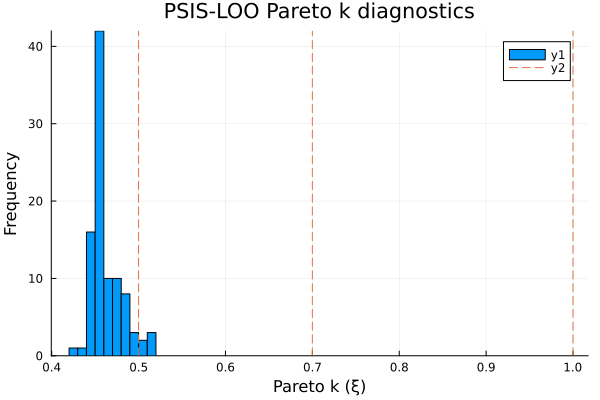

In [ ]:
## PSIS-LOO Pareto k diagnostics ----------------------------------------------------
loo = RunPSISLOO(model, chain_relabeled)
pareto_k = loo.pointwise(statistic = :pareto_k) |> collect
p = histogram(
    pareto_k;
    bins = :auto,
    xlabel = "Pareto k (ξ)",
    ylabel = "Frequency",
    title = "PSIS-LOO Pareto k diagnostics"
)
vline!(
    [0.5, 0.7, 1.0],
    linestyle = :dash,
)
savefig("output/pareto_k_$title.png")
display(p)



In [16]:
Pkg.status()

Status `C:\Users\michi\WorkSpace\gitwork\mich2000jp\hmm\Project.toml`
  [76274a88] Bijectors v0.15.14
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.8.1
  [31c24e10] Distributions v0.25.122
  [033835bb] JLD2 v0.6.3
  [2ab3a3ac] LogExpFunctions v0.3.29
⌃ [c7f686f2] MCMCChains v7.6.0
  [86f7a689] NamedArrays v0.10.5
  [a68b5a21] ParetoSmooth v0.7.16
  [91a5bcdd] Plots v1.41.3
  [10745b16] Statistics v1.11.1
  [4c63d2b9] StatsFuns v1.5.2
  [f3b207a7] StatsPlots v0.15.8
⌃ [fce5fe82] Turing v0.40.5
  [37e2e46d] LinearAlgebra v1.12.0
  [9a3f8284] Random v1.11.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [ ]:
plot(data_fp[])

Chains MCMC chain (1000×10×4 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 4
Samples per chain = 1000
parameters        = pcc[1], pcc[2], pcd[1], pcd[2], pdc[1], pdc[2], pdd[1], pdd[2], beta0[1], beta0[2]

Use `describe(chains)` for summary statistics and quantiles.
